<table>
    <tr>
        <td style="text-align:left">
            <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR9ItLTT_F-3Q30cu7ZCCoKmuFGBt22pe7pNA" alt="Logo Universidad" width="300"/>
        </td>
        <td>
            Departamento de Ciencias de la Computación y de la Decisión<br>
            Facultad de Minas<br>
            Universidad Nacional de Colombia<br>
            Optimizacion e IA 2024-2S<br><br>
            Docente: Maria Constanza Torres Madronero<br>
            <br>
            Contribuciones a la guia por: <br>
            - Deimer Miranda Montoya (2023)<br>
            - Luis Fernando Becerra Monsalve (2024)
        </td>    
        </td>    
    </tr>
</table>

### Clustering
Una tarea frecuente en aprendizaje de máquinas no supervisado es el agrupamiento o clustering. Estas técnicas permiten descubrir relaciones o patrones ocultos en los datos analizados. Existen diferentes métodos de agrupamiento, destacándose Kmeans por su simplicidad. En esta práctica compararemos Kmeans con técnicas de clustering que emplean métodos metaheuristicos como GA, PSO y ACO.

Primero generaremos una nube de datos para comparar los diferentes algoritmos. Para esto usaremos nuevamente herramientas disponibles en la librería sklearn.

In [1]:
#Importar librerias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

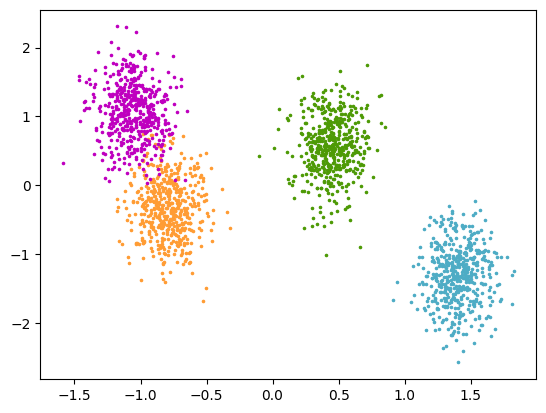

In [2]:
#Generacion de nubes de puntos
num_cluster = 4
n_samples = 2000
X, y_true = make_blobs(n_samples=n_samples, centers=num_cluster, n_features=2, random_state=37)
#Repetir con random_state=2
#Repetir con random_state=37 y num_cluster=5
scaler = preprocessing.StandardScaler().fit(X)
#Importante: normalizar los datos
X = scaler.transform(X)
#Visualizacion de los datos
colors = ["#4EACC5", "#FF9C34", "#4E9A06", 'm']
for k, col in enumerate(colors):
    cluster_data = y_true == k
    plt.scatter(X[cluster_data, 0], X[cluster_data, 1], c=col, marker=".", s=10)

# Kmeans
Para esta práctica usaremos la implementación clásica de Kmeans empleando el método disponible en la librería sklearn.

Coeff Silueta para Kmeans: =  0.6590880881097134


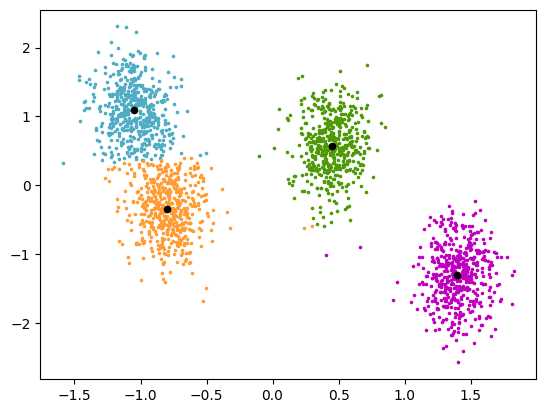

In [3]:
kmeans = KMeans(n_clusters=num_cluster, init='random',n_init=1)
kmeans.fit(X)

#Calculo del coeficiente de silueta
score = silhouette_score(X, kmeans.labels_)
print("Coeff Silueta para Kmeans: = ", score)

#Grafica de los cluster y centroides obtenidos
for k, col in enumerate(colors):
    filtered = X[kmeans.labels_==k]
    plt.scatter(filtered[:, 0], filtered[:, 1], c=col, marker=".", s=10)
    plt.scatter(kmeans.cluster_centers_[k, 0], kmeans.cluster_centers_[k, 1], c="black", marker="o", s=20)

### Algoritmo Genético


In [ ]:
#Instalacion de la libreria
#!pip install pygad

Parameters of the best solution : [-0.10891972 -0.11521501 -1.45080486  1.32870425  0.10340202 -0.05591734
  1.25786773 -1.03012441]
Fitness value of the best solution = 0.6561554007551739


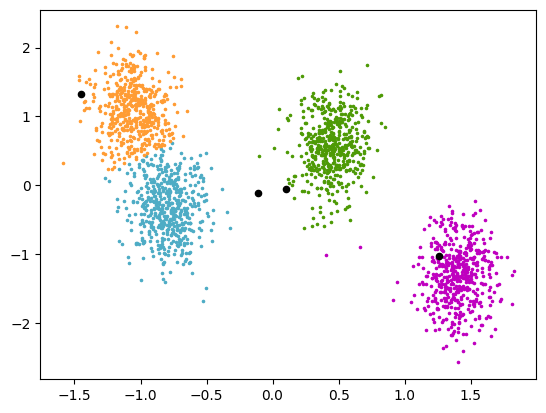

In [4]:
#Importar libreria pygad
import pygad

#Paso 1: Definire funcion fitness (funcion de aptitud)
#solution: arreglo con los centroides del cluster
#solution = [c1(x) c1(x) c2(x) c2(y)... cn(x) cn(y)]

def fitness_func(ga_instance, solution, solution_idx):
    global X, num_cluster
    k=0
    distance = np.zeros([n_samples,num_cluster])
    #ciclo para determinar la agrupacion de los datos
    #de acuerdo con los centroides
    for i in np.arange(0,num_cluster*2,2):
        centroid = np.array([solution[i], solution[i+1]])
        distance[:,k] = np.square(np.sum(np.power(X - centroid, 2), axis=1))
        k=k+1
    #se asigna cada cluster al centroide mas cercano
    solution_inx=distance.argmin(axis=1)
    fitness = silhouette_score(X, solution_inx)
    return fitness


#Paso 2: Preparamos los parametros para correr el algoritmo genetico
num_generations = 50
num_parents_mating = 10
fitness_function = fitness_func
sol_per_pop = 20
#Numero de genes en la solucion
num_genes = num_cluster*2
#Rangos iniciales para la poblacion inicial
init_range_low = -1
init_range_high = 1
#Metodo para la seleccion de padres
#"rws": Ruleta
#"tournament": Torneo
parent_selection_type = "rws"
keep_parents = 5
crossover_type = "single_point"
crossover_probability=0.8
mutation_type = "random"
mutation_probability = 0.1

#Instanciar el Algoritmo
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       crossover_probability = crossover_probability,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability)

#Corremos el algoritmo
ga_instance.run()

#Extraemos la mejor solucion
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness}")

#Obtenemos los cluster asociados a cada muestra
distance = np.zeros([n_samples,num_cluster])
k=0
for i in np.arange(0,(num_cluster)*2,2):
  centroid = np.array([solution[i], solution[i+1]])
  distance[:,k] = np.square(np.sum(np.power(X - centroid, 2), axis=1))
  k=k+1
GA_labels=distance.argmin(axis=1)

#Mostrar clusters
i=0
for k, col in enumerate(colors):
    filtered = X[GA_labels==k]
    plt.scatter(filtered[:, 0], filtered[:, 1], c=col, marker=".", s=10)
    plt.scatter(solution[i], solution[i+1], c="black", marker="o", s=20)
    i+=2

# PSO

In [ ]:
#Instalamos la libreria
#!pip install pyswarms

In [5]:
#Importamos la libreria
import pyswarms as ps

In [7]:
#Definicmos los hiperparametros
options = {'c1': 2, 'c2': 2, 'w':0.9}
dimensions = num_cluster*2 # Número de clústers (x) número de características
max_bound = 1*np.ones(dimensions)
min_bound = - max_bound
bounds = (min_bound, max_bound)
n_particles = 20
#solution = [c1(x) c1(x) c2(x) c2(y)... cn(x) cn(y)]
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds)

In [11]:
#Ajuste de la funcion objetivo
def funcion_objetivo(solution):
    global X, num_cluster, n_particles
    distance = np.zeros([n_samples, num_cluster])
    fitness = np.zeros(n_particles)

    # Ciclo para determinar la agrupación de los datos
    # de acuerdo con los centroides
    for j in range(n_particles):
        k = 0

        for i in np.arange(0, num_cluster*2, 2):
            centroid = np.array([solution[j, i], solution[j, i+1]])
            distance[:, k] = np.square(np.sum(np.power(X - centroid, 2), axis=1))
            k+=1

        # Se asigna cada clúster al centroide más cercano
        solution_inx = distance.argmin(axis=1)
        fitness[j] = 1-silhouette_score(X, solution_inx)
        
    return fitness

In [14]:
#Corremos el algoritmo PSO
cost, pos = optimizer.optimize(
    funcion_objetivo,
    iters=100,
)

2025-03-01 10:16:15,188 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 2, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.348
2025-03-01 10:16:58,109 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3479858893439347, best pos: [-0.49076164 -0.07531652  0.52597077 -0.78339568 -0.9340592   0.8774381
  0.04086157  0.25979344]


Parameters of the best solution : [-0.75946242  0.44254854  0.3380067   0.55524899  0.67648134 -0.85669435
 -0.79602477  0.11874956]
Score : 0.6497699037465019


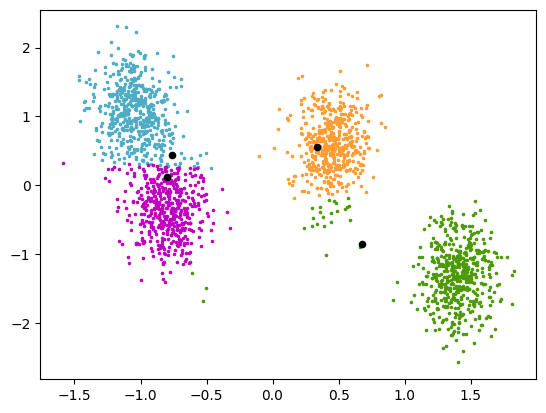

In [13]:
#Extraemos la mejor solucion
solution = optimizer.swarm.best_pos
print(f"Parameters of the best solution : {solution}")

#Obtenemos los cluster asociados a cada muestra
distance = np.zeros([n_samples,num_cluster])
k=0
for i in np.arange(0,(num_cluster)*2,2):
  centroid = np.array([solution[i], solution[i+1]])
  distance[:,k] = np.square(np.sum(np.power(X - centroid, 2), axis=1))
  k=k+1
PSO_labels=distance.argmin(axis=1)
print(f"Score : {silhouette_score(X, PSO_labels)}")

#Mostrar clusters
i=0
for k, col in enumerate(colors):
    filtered = X[PSO_labels==k]
    plt.scatter(filtered[:, 0], filtered[:, 1], c=col, marker=".", s=10)
    plt.scatter(solution[i], solution[i+1], c="black", marker="o", s=20)
    i+=2